In [1]:
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import pandas as pd

# What happens in this notebook?

1. Additional static variables are added - lake area and lake depth
2. Certain variables are removed (due to their missingness or their expected availability outside the study area)
3. Data is split into train, validation, and test partitions
  * The test partition consists of lakes and years that are not represented in the validation and train partitions
    * Notably, the test partition consists of the most recent years (2010-2017)
  * The validation and train partitions share lakes, but contain mutually exclusive years
    * Validation = 2005-2009
    * Train = 1980-2004

# Configuration

### Inputs

In [2]:
out_dir = "../out/"
model_ready_data_fpath = out_dir + 'model_ready_sequences.npz'
matching_df_fpath = out_dir + "matching_sources.csv"

mapping_reference = "../in/MN_ice/raw_data_from_DNR/lake_ice_id_spreadsheet.xlsx"

### Values

In [3]:
random_seed = 123

date_format = '%Y-%m-%d'

vars_to_keep = ['ShortWave', 'LongWave', 'AirTemp', 'RelHum', 'WindSpeed', 'Rain',
                'Snow', 'ice', 'temp_0_x', 'MaxDepth', 'LakeArea']

# compatible with earlier efforts, leaves enough to train and eval with
# a 'soft' test set can be larger, consisting of train/eval lakes during test years
# and test lakes during train/eval years
test_set_prop = 0.08

test_start_year = 2010
valid_start_year = 2005

# num times to attempt to find a test set that maximizes training data
try_n_test_partitions = 10000

### Outputs

In [4]:
train_data_fpath = out_dir + 'train_data.npz'
valid_data_fpath = out_dir + 'valid_data.npz'
soft_test_data_fpath = out_dir + 'soft_test_data.npz'
test_data_fpath = out_dir + 'test_data.npz'

# Import

In [5]:
model_ready_data = np.load(model_ready_data_fpath, allow_pickle = True)

lat_lon_ref_df = pd.read_excel(mapping_reference,
                               usecols=['dow num', 'lat', 'long'])

In [6]:
x = model_ready_data['x']
y = model_ready_data['y']
dates =  model_ready_data['dates']
DOW =  model_ready_data['DOW']
variables =  model_ready_data['features']

print('Number of sequences before this work... ', str(x.shape[0]))

Number of sequences before this work...  5104


# Add in area and depth from TOHA metadata

In [7]:
matching_df = pd.read_csv(matching_df_fpath)
matching_df

,Unnamed: 0,DOW,group,meteo_file,nhdhr,depth,area
0,0,3065700,06_N46.00-47.00_W94.50-97.00,nldas_meteo_N46.8125-46.8125_W96.1875-96.1875.csv,121545300,21.9456,756697.4
1,1,6015200,09_N45.00-46.00_W94.50-97.00,nldas_meteo_N45.4375-45.4375_W96.5625-96.5625.csv,122548488,4.8768,48496840.0
2,2,37004600,09_N45.00-46.00_W94.50-97.00,nldas_meteo_N45.0625-45.0625_W95.9375-95.9375.csv,122551004,3.0480,14960190.0
3,3,37004601,09_N45.00-46.00_W94.50-97.00,nldas_meteo_N45.0625-45.0625_W95.9375-95.9375.csv,122551004,3.0480,14960190.0
4,4,3029100,06_N46.00-47.00_W94.50-97.00,nldas_meteo_N46.9375-46.9375_W95.8125-95.8125.csv,121544299,6.7056,936557.7
...,...,...,...,...,...,...,...
1058,1058,69027700,04_N45.50-48.00_W92.00-93.00,nldas_meteo_N47.8125-47.8125_W92.0625-92.0625.csv,105954667,7.3152,456057.3
1059,1059,38062000,01_N48.00-49.50_W89.50-97.25,nldas_meteo_N48.0625-48.0625_W91.4375-91.4375.csv,80997051,11.5824,242621.6
1060,1060,38014700,01_N48.00-49.50_W89.50-97.25,nldas_meteo_N48.0625-48.0625_W91.0625-91.0625.csv,80997393,23.1648,518915.9
1061,1061,16081200,01_N48.00-49.50_W89.50-97.25,nldas_meteo_N48.0625-48.0625_W91.0625-91.0625.csv,80994457,11.5824,151548.4


In [8]:
assert np.sum(np.isnan(matching_df['area'])) == np.sum(np.isnan(matching_df['depth'])) == 0

In [9]:
depth_vals = np.ones([x.shape[0], x.shape[1]])
area_vals = np.ones([x.shape[0], x.shape[1], 1])

count = 0
for dow in DOW:
    depth_val = matching_df[matching_df['DOW'] == dow]['depth'].item()
    area_val = matching_df[matching_df['DOW'] == dow]['area'].item()
    
    depth_vals[count] = depth_val*depth_vals[count]
    area_vals[count] = area_val*area_vals[count]
    
    count += 1

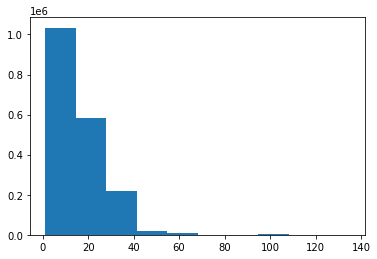

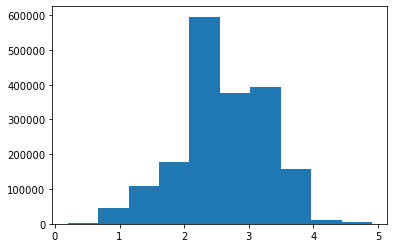

In [10]:
plt.hist(depth_vals.flatten())
plt.pause(0.0001)
plt.hist(np.log(depth_vals.flatten()));

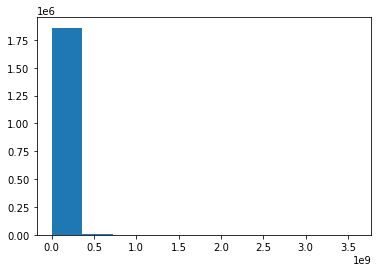

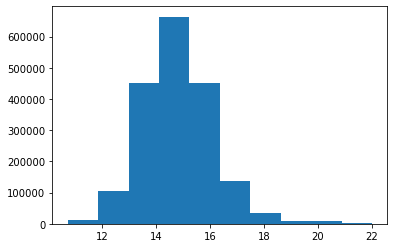

In [11]:
plt.hist(area_vals.flatten())
plt.pause(0.0001)
plt.hist(np.log(area_vals.flatten()));

In [12]:
# overwrite the existing max depth (associated with deep water temp estimnates)
x[:, :, np.argwhere(variables == 'MaxDepth').item()] = np.log(depth_vals)

# add in lake area
x = np.concatenate([x, np.log(area_vals)], axis = 2)
variables = np.concatenate([variables, ['LakeArea']])

# Demonstrate existing data missingness

In [13]:
# We dont really need the 366th day after July 1 on leap years
#   because it will almost surely be ice free.
# Additionally, the 366th day is nan for non leap years.
temporary_x = x[:, :365, :].copy()

# Determine how many sequences have a NaN present for each variable
for i in range(len(variables)):
    nan_free_seq_count = 0
    for j in range(temporary_x.shape[0]):
        if np.sum(np.isnan(temporary_x[j, :, i])) == 0:
            nan_free_seq_count += 1
    print(i, variables[i], '\t\t', np.round(nan_free_seq_count / temporary_x.shape[0], 2))

0 ShortWave 		 0.89
1 LongWave 		 0.89
2 AirTemp 		 0.89
3 RelHum 		 0.89
4 WindSpeed 		 0.89
5 Rain 		 0.89
6 Snow 		 0.89
7 kd 		 0.85
8 ice 		 0.85
9 rad_0 		 0.85
10 temp_0_x 		 0.85
11 temp_0_y 		 0.68
12 temp_MaxDepth_x 		 0.85
13 temp_MaxDepth_y 		 0.68
14 MaxDepth 		 1.0
15 LakeArea 		 1.0


**Working decision:** dont use PGDL estimates for water temperature because they are missing too often.

# Omit variables or rows that provide missingness

### Omit variables

In [14]:
vars_to_keep_ids = np.isin(variables, vars_to_keep)

In [15]:
non_omitted_variables = variables[vars_to_keep_ids]
print(non_omitted_variables)

improved_x = temporary_x[:, :, vars_to_keep_ids]

del(temporary_x)

['ShortWave' 'LongWave' 'AirTemp' 'RelHum' 'WindSpeed' 'Rain' 'Snow' 'ice'
 'temp_0_x' 'MaxDepth' 'LakeArea']


### Omit rows

In [16]:
# Determine where data is missing and what percent are missing
nan_free_seq_count = 0
nan_free_indices = []
for j in range(improved_x.shape[0]):
    if np.sum(np.isnan(improved_x[j])) == 0:
        nan_free_seq_count += 1
        nan_free_indices.append(j)
nan_free_indices = np.asarray(nan_free_indices)

perc_missing = 1  - (nan_free_seq_count / improved_x.shape[0])
perc_missing

0.14596394984326022

In [17]:
improved_x = improved_x[nan_free_indices]
# Also get rid of that extra day on leap years here
y = y[nan_free_indices, :365]
dates = dates[nan_free_indices, :365]
DOW = DOW[nan_free_indices].astype(int)
variables = non_omitted_variables

In [18]:
print('Number of sequences remaining... ', str(improved_x.shape[0]))

Number of sequences remaining...  4359


# Identify partitions by lake identifier (DOW)

Train, validation, and test sets will be mutually exclusive sets of different lakes. Data from these lake sets should approximately span the entire temporal range

In [19]:
df = pd.DataFrame({"DOW":DOW.astype(int),
                   "dates":dates[:, 0].astype(np.datetime64)})
df = df.dropna()
df['dates'] = df['dates'].astype(np.datetime64)

lat_lon_ref_df = lat_lon_ref_df.rename(columns = {'dow num':'DOW'})
df = df.merge(lat_lon_ref_df, how = 'left', on = 'DOW')

df['year'] = [date.year for date in df['dates']]

### Figure out what % of the data each lake represents

In [20]:
DOW_value_counts = df['DOW'].value_counts()
DOW_proportions = DOW_value_counts / len(df)
DOW_proportions = pd.DataFrame(DOW_proportions)
DOW_proportions = DOW_proportions.reset_index()
DOW_proportions = DOW_proportions.rename(columns = {'DOW':'prop',
                                                    'index':'DOW'})
DOW_proportions

,DOW,prop
0,10005900,0.008718
1,34007900,0.008718
2,4013000,0.008718
3,29025000,0.008488
4,27013300,0.008488
...,...,...
620,40006300,0.000229
621,4013001,0.000229
622,4021700,0.000229
623,47004901,0.000229


In [21]:
df = df.merge(DOW_proportions, how = 'left', on = 'DOW')

# Sample different lakes into the test set many times

Always achieve a desired test set proportion, then track valid/train size. After lots of iterations, select the sample of test set lakes that maximizes training data.

Years are set/fixed based on a preference for evaluating future years. 8 years (2010-2017, inclusive) was seen as a minimum good test set.

In [22]:
def partition_by_lakes(dataset, possible_lakes, desired_prop, total_N, rng):
    
    # arguments
    #     `dataset` is the dataset we're partitioning.
    #        I assume it has a "DOW" column
    #     `possible_lakes` are the DOWs that we sample.
    #        As the sampling continues, we remove values.
    #     `desired_prop` is the proportion of the data set
    #        that we want this partition to cover.
    #     `total_N` is the number of available sequences across
    #        all lakes and years
    #     `rng` is a np.random.RandomState object (opposed to
    #        np.random.seed setting)
    # returns
    #     `partition_lakes` are the random DOWs representing
    #        the desired minimum proportion of the data set
    
    partition_lakes = []
    cumulative_sum = 0 

    while cumulative_sum < desired_prop:
        # add a random new lake to the partition
        rand_DOW = rng.choice(possible_lakes)
        partition_lakes.append(rand_DOW)

        # subset the data set to those sampled partitions
        # and determine what % we are at
        cumulative_subset = dataset[dataset.DOW.isin(partition_lakes)]
        cumulative_sum = cumulative_subset.shape[0] / total_N

        # sample without replacement
        possible_lakes.remove(rand_DOW)
    
    return(partition_lakes)

In [23]:
dev_period = df[df['year'] < test_start_year]
test_period = df[df['year'] >= test_start_year]

In [24]:
RNG = np.random.RandomState(random_seed)

In [25]:
%%time

test_lake_candidates = []
partition_sizes = np.zeros([try_n_test_partitions, 3])

for count in range(try_n_test_partitions):
    # sample random lakes that are observed in the test years for possible exclusion
    # from train/valid sets
    test_lakes = partition_by_lakes(test_period,
                                    list(test_period['DOW'].copy()),
                                    test_set_prop,
                                    df.shape[0],
                                    RNG)

    # Make the test set consist exclusive lakes (on top of exclusive years)
    test_df = test_period[test_period['DOW'].isin(test_lakes)]

    # Train/valid will be earlier period omitting test lakes
    dev_df = dev_period[dev_period['DOW'].isin(test_lakes) == False]

    # Separate train/valid by year
    valid_df = dev_df[dev_df['year'] >= valid_start_year]
    train_df = dev_df[dev_df['year'] < valid_start_year]

    # Keep track of each random attempt...
    # ...partition sizes (relative to whole)
    partition_sizes[count] = (train_df.shape[0] / df.shape[0],
                              valid_df.shape[0] / df.shape[0],
                              test_df.shape[0] / df.shape[0])
    # ...test set lakes omitted
    test_lake_candidates.append(test_lakes)

Wall time: 8min 59s


In [26]:
# what maximizes the training set with the desired test set prop?
found_iteration = np.argmax(partition_sizes[:, 0])
test_lakes = test_lake_candidates[found_iteration]

# 50/16.5/8 split
partition_sizes[found_iteration, :]

array([0.49965588, 0.16563432, 0.08029365])

In [27]:
# test years and test lakes
test_df = test_period[test_period['DOW'].isin(test_lakes)]

# Train/valid will be earlier period omitting test lakes
dev_df = dev_period[dev_period['DOW'].isin(test_lakes) == False]

# Separate train/valid by year
valid_df = dev_df[dev_df['year'] >= valid_start_year]
train_df = dev_df[dev_df['year'] < valid_start_year]

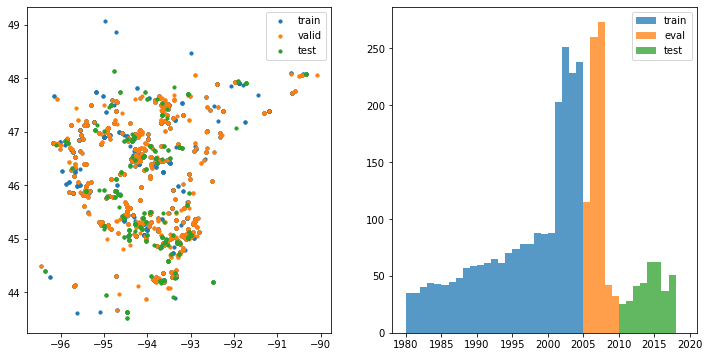

In [28]:
# plot the partitions
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].scatter(train_df['long'], train_df['lat'], s = 10, label = 'train')
ax[0].scatter(valid_df['long'], valid_df['lat'], s = 10, label = 'valid')
ax[0].scatter(test_df['long'], test_df['lat'], s = 10, label = 'test')
ax[0].legend();

# transparency to demostrate no overlap
plt.hist(train_df['year'], bins = np.arange(1980, 2020), label = 'train', alpha = 0.75)
plt.hist(valid_df['year'], bins = np.arange(1980, 2020), label = 'eval', alpha = 0.75)
plt.hist(test_df['year'], bins = np.arange(1980, 2020), label = 'test', alpha = 0.75)
plt.legend();

In [29]:
def save_partition_data(indices, fpath):
    # subset all the objects
    part_x = improved_x[indices]
    part_y = y[indices]
    part_dates = dates[indices]
    part_DOW = DOW[indices]
    
    part_data = {'x':part_x,
                 'y':part_y,
                 'dates':part_dates,
                 'DOW':part_DOW,
                 'features':non_omitted_variables}
    
    np.savez_compressed(fpath, **part_data)

In [30]:
soft_test_indices = []
for i in df.index:
    if (i not in train_df.index) and (i not in valid_df.index) and (i not in test_df.index):
        soft_test_indices.append(i)

In [31]:
assert (len(soft_test_indices) + train_df.shape[0] + valid_df.shape[0] + test_df.shape[0]) == df.shape[0]

In [32]:
save_partition_data(train_df.index, train_data_fpath)
save_partition_data(valid_df.index, valid_data_fpath)
save_partition_data(soft_test_indices, soft_test_data_fpath)
save_partition_data(test_df.index, test_data_fpath)

<br><br><br><br>

# Lake overlap checking

In [33]:
# Percent of valid lakes appearing in test set
len([dow for dow in valid_df['DOW'].unique() if dow in test_df['DOW'].unique()]) / valid_df['DOW'].unique().shape[0]

0.0

In [34]:
# Percent of valid lakes appearing in train set
#   Not 100% due to timing of available observations
len([dow for dow in valid_df['DOW'].unique() if dow in train_df['DOW'].unique()]) / valid_df['DOW'].unique().shape[0]

0.7119565217391305

In [35]:
# Percent of train lakes appearing in test set
len([dow for dow in test_df['DOW'].unique() if dow in train_df['DOW'].unique()]) / test_df['DOW'].unique().shape[0]

0.0